# Smooting

## Moving average (MA)

The class of moving average smoothing filters smoothes data by replacing each data point by a (weighted) average over a windows around that data point. The simple (unweighted) moving avrage is defined as:

$\text{SMA}_m[X(t)] = \sum^{(m-1)/2}_{s=-(m-1)/2} X(t+s) \frac{1}{m} $


## Kalmogorov-Zurbenko filter

Definition from Wikipedia

$\text{KZ}_{m,k} [X(t)] = \sum^{k(m-1)/2}_{s=-k(m-1)/2} X(t+s) a^{m,k}_s$

The coefficients $a^{m,k}_s = \frac{c^{m,k}_s}{m^k}$ are defined by the solutions to the equation

$\sum^{k(m-1)}_{r=0} z^r c^{k,m}_{r-k(m-1)/2} = \left({\sum_{r=0}^{m-1}} z^r\right)^k$

The KZ-filter can also be seen as k-times iterated $\text{SMA}_m[X(t)]$

KZFT extension not necessary -- no seasonality.

## Kalman filter

Can be used to smooth data and estimate parameters (for example parameters of EoM) from noisy data with missing datapoints.

overkill...

In [151]:
function filter_MA(m::Int, X::AbstractArray{T,1}) where T <: Number
    res = deepcopy(X) 
    offset = trunc(Int,m/2)
    res[1+offset] = sum(@view X[1:m])/m
    for (ii,i) in enumerate((2+offset):(length(X)-offset))
        res[i] = res[i-1] + (X[m+ii] - X[ii])/m
    end
    return res
end

function filter_MA!(res::AbstractArray{T,1}, m::Int, X::AbstractArray{T,1}) where T <: Number 
    offset = trunc(Int,m/2)
    res[1+offset] = sum(@view X[1:m])/m
    for (ii,i) in enumerate((2+offset):(length(X)-offset))
        res[i] = res[i-1] + (X[m+ii] - X[ii])/m
    end
    return res
end

function filter_KZ(m::Int, k::Int, X::AbstractArray{T,1}) where T <: Number
    res = filter_MA(m, X)
    for ki in 2:k
        res = filter_MA!(res, m, res)
    end
    return res
end

filter_KZ (generic function with 1 method)

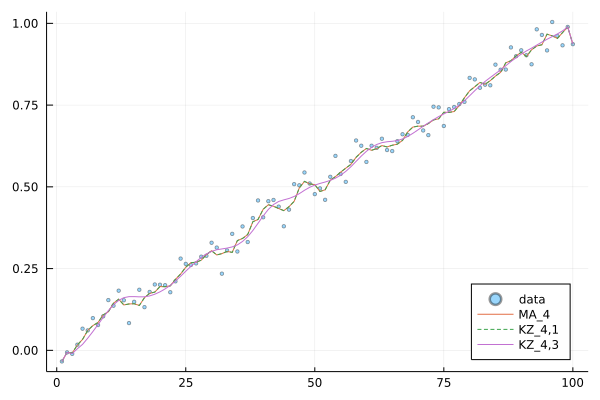

In [153]:
using Plots
testdata = [(i/100 + randn()/30) for i in 1:100]
scatter(testdata, markersize=2, label="data", alpha=0.4, legend=:bottomright)
plot!(filter_MA(4,testdata), label="MA_4")
plot!(filter_KZ(4,1,testdata), linestyle=:dash, label="KZ_4,1")
plot!(filter_KZ(4,3,testdata), label="KZ_4,3")

# Mixing

## $x$, $1-x$

## tanh

# Sampling order and tails in ED/CT-QMC

## Modified sampling

### Expansion orders in CT-QMC

ED usually works by computing Green's functions from the Lehman representation and truncating small contributions.
From the definition of the one particle Green's function in Matsubara space $G(k,i \omega_{n}) = \frac{1}{Z} \sum_{m,o} 
    ({e^{-\beta E_m} + e^{-\beta E_o}}) \frac{|{\langle m | c^\dagger_k | o \rangle}|^2}{i\omega_n +  E_o - E_m} $
and $\omega_n = \frac{ (2n+1)\pi}{\beta}$,
we would expect the truncation error to also decrease with $\sim \frac{1}{n}$ for a fixed temperature and energy truncation. Increasing $\beta$ will exponentially supress the contributions, which can be expected to also decrease the error.
We therefore expect the error to be dominant for small $\omega$ and $\beta$.

Luckily, this is a parameter region for which CTQMC methods are very well suited.

Notes:

CT-INT has average perturbation order $\langle \text{Order} \rangle = \frac{1}{Z} \sum_\mathcal{C} n_\mathcal{C} w_\mathcal{C} = - \beta E_\text{pot} + \frac{\beta U}{2} \langle n_\uparrow + n_\downarrow \rangle$ and the perturbation order is Gaussian distributed (see Stobbe msc., p. 96). TODO: derive $\sigma$ it is proportional to $U$.

CT-HYB has average perturbation order $\langle \text{Order} \rangle =  - \beta E_\text{kin}$ 

from p. Werner. Single bath-site AIM: $p(\text{Order}) \sim \frac{(\beta |V|)^{2n}}{(2n)!}$

There arguments wil be used to construct a combined solver, using the ED results at all frequencies as a prior for the Monte Carlo sampling. 


### MCMC

Monte Carlo is a class of methods designed to sample the distribution of an unkown distribution with known evaluation function (i.e. function that can tell wether or not a point falls into the distribution), estimate integrals or transform distribution functions.
The have in common, that we approximate an integral over configurations $\mathcal{C}$ by a finite sum:

$\mathbb{E}_\rho[f] = \int f(C) \rho(C) \mathrm{d}C \approx \sum_\mathcal{C} p({\mathcal{C}_n}) f(\mathcal{C}_n)$

The probability distribution of the configurations $\mathcal{C}$ can be sampled for example by using Markov-Chain methods (approximating distributions is of course a general property of Markov Chains).
In case of CTQMC, we use the Metropolis-Hastings algorithm to generate samples of the form:

repeat until enough samples are accepted:

    1. draw x_i from proposal distribution
    2. Test x_i against posterior distribution and accept/reject
    3. If accepted: save x_i
        
Usually the number of samples is to large to save the full history of all generated samples. There one uses "online algorithms" to only update the mean and variance of $x$.

Our goal is to use the better tails from ED to augment and smooth out the Monte Carlo data.



### Bayesian Inference

The central idea of Bayesian inference is to start with a prior believe distribution and adjust this distribution with each new data point. In our scenario this is especially usefull, since we already know, that the resulting data follows a Gaussian distribution.

Let $E$ be a vector of events/observations and $M$ a list of models. Then Bayes theorem states:

$P(M | E) = \frac{P(E | M)}{\sum_n P(E  | M_n ) P(M_n)} \cdot P(M)$

$P(E | M)$ is called likelihood function.

We already know, that our posterior probability must be a normal distribution and only $\mu$ and $\sigma$ have to be determined. 
In this context one usually calls the parameters of distributions hyperparameters.

Bayesian inference with identical prior and posterior where only hyperparameters are estimated is called conjugate prior method.


### Conjugate prior

Let $\theta$ be the list of hyperparameters (in our case $\theta = (\mu, \sigma)$. Then Bayes gives us:

$p(\theta | x) = \frac{p(x|\theta) p(\theta)}{\int_{\theta'} p(x|\theta') p(\theta') \mathrm{d}\theta'}$

If posterior und prior (i.e. $p(\theta | x)$ and $p(\theta)$) lie wihtin the same distribution family, they are called conjugate distributions.

Since we know, that our posterior must be a normal distribution it seems to be a reasonable ansatz, to choose a conjugate prior approach. 

The likelihood in this case is dependent on the known parameters.
We want to let the data from the CT-QMC algorithm determine $\mu$ and $\sigma$ of the posterior, given the prior from ED. 
The assiciated likelihood function in this case is the Normal-inverse gamma distribution (note: this becomes more easy, if one is only interested in $\mu$, in this case prior, likelihood and posterior are all normal distributions).

For a Normal posterior with unkown mean and variance, the conjugate prior is the Normal-inverse-gamma distribution, with PDF:
$P(x) = \frac{\sqrt(\lambda)}{\sqrt{2 \pi \sigma^2}} \frac{\beta^2}{\Gamma(\alpha)} (\frac{1}{\sigma^2})^{\alpha+1} \exp \left({- \frac{2 \beta + \lambda(x-\mu)^2}{2 \sigma^2} }\right)$

For $\lambda$ observations of the mean, resulting in the sample mean $\mu_0$ and $2 \alpha$ observations for $\sigma_0$
.... from wikipedia


For only $\hat{\mu}$ estimation of posterior parameter and known $\sigma$ we obtain a substantially more simple result.
$\mu_0$ and $\sigma_0$ are the parameters of the prior.


$\sigma = \frac{1}{\sigma^{-2}_0 + n \cdot \sigma^{-2}} $


$\mu = \frac{1}{\sigma^{-2}_0 + n \cdot \sigma^{-2}} \left({\frac{\mu_0}{\sigma^2_0}} + \frac{\hat{\mu}}{\sigma^2} \right)$

Note, that this method can be conceptualized as an extension of naive sampling. Letting $\sigma_0 \to \infty$ (i.e. assuming a flat prior) results.

The likelihood provides a method to predict MC data from ED data.
Given the arguments above, this should provide a good approximation in the tails.


### Asymptotically exact data augmentation (ADAX) instead?


# Application to CT-QMC

From the arguments above a good heuristic of the prior for $G_\text{imp}(i \omega_n)$, sampled with CT-INT should be $p(\theta | \alpha) = p(\mu_n, \sigma_n | \beta, U, n, \mu_{n,\text{ED}}) = \mathcal{N}(\mu_{n,\text{ED}}, \frac{c_1 \beta U}{n \sqrt{s}})$ , and for CT-HYB $p(\theta | \alpha) = p(\mu_n, \sigma_n | \beta, U, n, \mu_{n,\text{ED}}) = \mathcal{N}(\mu_{n,\text{ED}}, \frac{c_2 \beta}{n \sqrt{s}})$. $c_1, c_2$ are empirical parameters to be set after some testing, $\mu_n = G_\text{imp,ED}(i\omega_n)$ and $s$ is the number of Monte Carlo samples for that frequency (see also plots from stobbe msc, p. 107)